In [1]:
librarian::shelf(tidyverse, tidymodels, DataExplorer, GGally, corrplot, plotly, viridis,
pROC, randomForest, factoextra, cluster, ggthemes, ggridges, scales, vcd, kableExtra, DT, 
MASS, Rtsne, tsne, umap, conflicted)

In [2]:
getwd()

[1] "c:/Users/oland/Desktop/R stuff/LoanDefault"

In [3]:
# Set custom theme

theme_custom <- function() {
  theme_minimal() +
    theme(
      plot.background = element_rect(fill = "white", color = NA),
      panel.grid.major = element_line(color = "gray90"),
      panel.grid.minor = element_blank(),
      plot.title = element_text(size = 16, face = "bold", hjust = 0.5),
      plot.subtitle = element_text(size = 12, color = "gray30", hjust = 0.5),
      axis.title = element_text(size = 12, face = "bold"),
      axis.text = element_text(size = 10),
      legend.title = element_text(size = 12, face = "bold"),
      legend.text = element_text(size = 10),
      legend.position = "right"
    )
}

theme_set(theme_custom())



# 1. Introduction

This document presents an intensive exploratory loan_data analysis (EDA) and statistical analysis of a loan default loan_dataset. The goal is to uncover patterns, relationships, and insights that can help predict loan defaults. The analysis includes:

- loan_data preprocessing and cleaning
- Univariate analysis with advanced visualizations
- Bivariate and multivariate analysis
- Correlation analysis with sophisticated visualizations
- Feature importance and selection
- Statistical modeling and predictive analysis
- Advanced dimensionality reduction and visualization techniques

Let's begin by loading and examining the loan_dataset.

# 2. loan_data Loading and Initial Exploration

In [4]:
conflicted::conflicts_prefer(dplyr::select)
tidymodels_prefer()

[conflicted] Will prefer dplyr::select over any other package.


In [5]:
loan_data <- read_csv("dataset/Loan_Default.csv")

Rows: 148670 Columns: 34
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (21): loan_limit, Gender, approv_in_adv, loan_type, loan_purpose, Credit...
dbl (13): ID, year, loan_amount, rate_of_interest, Interest_rate_spread, Upf...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
loan_data %>% 
  janitor::clean_names() %>%
  select(-id) -> loan_data


In [7]:
# Select 20000 observations while maintaining the distribution in the target variable
# for fast modelling and visualization before upscaling
library(caTools)
set.seed(42)

split_ratio <- 20000 / nrow(loan_data)
split_index <- sample.split(loan_data$status, SplitRatio = split_ratio)

# Extract the sample
data <- loan_data[split_index, ]

In [8]:
# Verify if the distribution is maintained
print(table(loan_data$status) / nrow(loan_data))
print(table(data$status) / nrow(data))


        0         1 
0.7535549 0.2464451 

      0       1 
0.75355 0.24645 


In [9]:
cat("Dimensions of the loan_dataset", dim(data)[1], "rows and ", dim(data)[2], " columns")

Dimensions of the loan_dataset 20000 rows and  33  columns

In [10]:
head(data)

# A tibble: 6 × 33
   year loan_limit gender approv_in_adv loan_type loan_purpose credit_worthiness
  <dbl> <chr>      <chr>  <chr>         <chr>     <chr>        <chr>            
1  2019 cf         Joint  pre           type1     p1           l1               
2  2019 cf         Joint  pre           type1     p3           l1               
3  2019 cf         Sex N… nopre         type1     p3           l1               
4  2019 cf         Female nopre         type1     p1           l1               
5  2019 cf         Female nopre         type1     p1           l1               
6  2019 cf         Male   nopre         type3     p4           l1               
# ℹ 26 more variables: open_credit <chr>, business_or_commercial <chr>,
#   loan_amount <dbl>, rate_of_interest <dbl>, interest_rate_spread <dbl>,
#   upfront_charges <dbl>, term <dbl>, neg_ammortization <chr>,
#   interest_only <chr>, lump_sum_payment <chr>, property_value <dbl>,
#   construction_type <chr>, occupancy_type <chr>, 

In [11]:
skimr::skim(data) %>% 
  as_tibble() %>% 
  kable(caption = "Summary Statistics of the loan loan_data")



Table: Summary Statistics of the loan loan_data

|skim_type |skim_variable             | n_missing| complete_rate| character.min| character.max| character.empty| character.n_unique| character.whitespace| numeric.mean|   numeric.sd|   numeric.p0|  numeric.p25|  numeric.p50|  numeric.p75| numeric.p100|numeric.hist |
|:---------|:-------------------------|---------:|-------------:|-------------:|-------------:|---------------:|------------------:|--------------------:|------------:|------------:|------------:|------------:|------------:|------------:|------------:|:------------|
|character |loan_limit                |       483|       0.97585|             2|             3|               0|                  2|                    0|           NA|           NA|           NA|           NA|           NA|           NA|           NA|NA           |
|character |gender                    |         0|       1.00000|             4|            17|               0|                  4|                

In [12]:
# Convert all character loan_amounts to factors

data <- data %>% mutate_if(is.character, as.factor)

## Missing loan_data Analysis


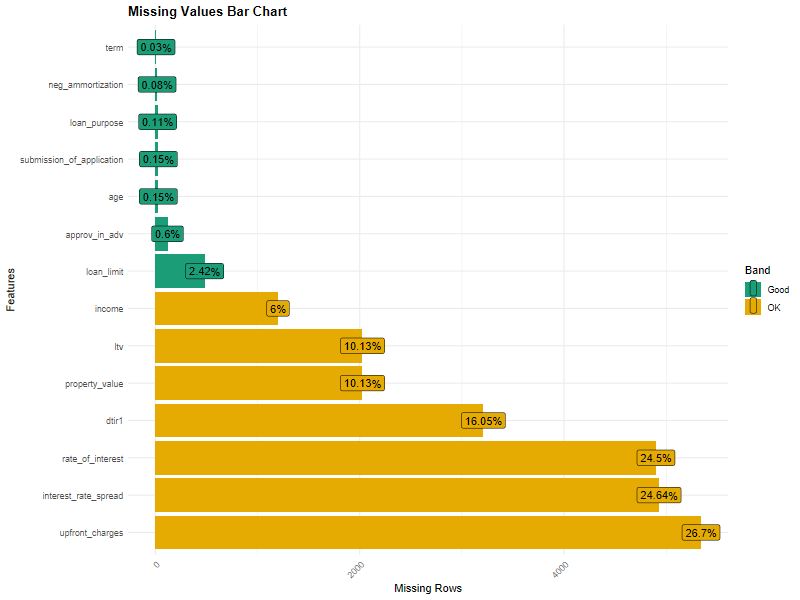

In [13]:
plot_missing(data, missing_only = TRUE, title = "Missing Values Bar Chart") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
        plot.title = element_text(face = "bold"))

In [14]:
#Convert all character variables to factors
data <- data %>% 
  mutate_if(is.character, as.factor)

head(data)

# A tibble: 6 × 33
   year loan_limit gender approv_in_adv loan_type loan_purpose credit_worthiness
  <dbl> <fct>      <fct>  <fct>         <fct>     <fct>        <fct>            
1  2019 cf         Joint  pre           type1     p1           l1               
2  2019 cf         Joint  pre           type1     p3           l1               
3  2019 cf         Sex N… nopre         type1     p3           l1               
4  2019 cf         Female nopre         type1     p1           l1               
5  2019 cf         Female nopre         type1     p1           l1               
6  2019 cf         Male   nopre         type3     p4           l1               
# ℹ 26 more variables: open_credit <fct>, business_or_commercial <fct>,
#   loan_amount <dbl>, rate_of_interest <dbl>, interest_rate_spread <dbl>,
#   upfront_charges <dbl>, term <dbl>, neg_ammortization <fct>,
#   interest_only <fct>, lump_sum_payment <fct>, property_value <dbl>,
#   construction_type <fct>, occupancy_type <fct>, 

In [15]:
# Remove Zero Variance columns and then perform knn imputation
data <- recipe(status ~ ., data) %>% 
  step_zv() %>% 
  step_impute_knn(all_predictors()) %>% 
  prep() %>% 
  bake(new_data = NULL)

There were 50 or more warnings (use warnings() to see the first 50)


In [ ]:
recipe(status ~ ., data) %>% 
  step_zv()

In [16]:
colSums(is.na(data))

                     year                loan_limit                    gender 
                        0                         0                         0 
            approv_in_adv                 loan_type              loan_purpose 
                        0                         0                         0 
        credit_worthiness               open_credit    business_or_commercial 
                        0                         0                         0 
              loan_amount          rate_of_interest      interest_rate_spread 
                        0                         0                         0 
          upfront_charges                      term         neg_ammortization 
                        0                         0                         0 
            interest_only          lump_sum_payment            property_value 
                        0                         0                         0 
        construction_type            occupancy_type 

# 3. Univariate Analysis

## 3.1 Distribution of Numeric loan_amounts

In [17]:
data$status <- factor(data$status, 
  levels = c(0, 1), 
  labels = c("No", "Yes"))

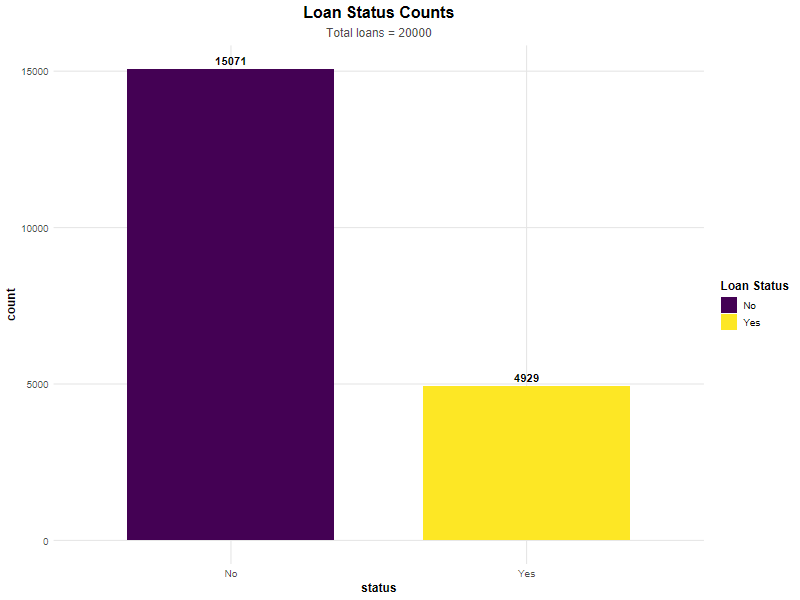

In [18]:
status_counts <- data %>% 
  count(status) %>% 
  mutate(percentage = n / sum(n) * 100)

ggplot(data, aes(status, fill = status)) +
  geom_bar(width = 0.7) +
  geom_text(stat = "count", 
             aes(label = after_stat(count)),
             vjust = -0.5,
             size = 4, fontface = "bold") +
  scale_fill_viridis_d(option = "D") +
  labs(title = "Loan Status Counts",
      subtitle = paste("Total loans =", nrow(data)),
      fill = "Loan Status") +
  theme_custom() -> p1

p1

In [ ]:
numeric_cols <- data %>% 
  select_if(is.numeric) %>% 
  names()

numeric_data <- data %>% 
  select(any_of(c(numeric_cols, status))) %>% 
  pivot_longer(cols = -status, names_to = "features", values_to = "values")

p2 <- ggplot(numeric_data, aes(values, fill = status)) +
  geom_density(alpha = 0.6) +
  geom_rug(alpha = 0.6, color = "#e74c3c") +
  facet_wrap(~features, scales = "free") +
  labs(title = "Feature Distributions by Loan Status",
  x = "Value", y = "Density") +
  scale_fill_manual(values = c("No" = "#66c2a5", 
  "Yes" = "#fc8d62")) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1),
     legend.position = "bottom")

p2
  

In [88]:
library(gridExtra)
numeric_cols <- imputed_data %>% 
  select(-year) %>% 
  select_if(is.numeric) %>% 
  names()

In [89]:
numeric_features$features <- as.factor(numeric_features$features)

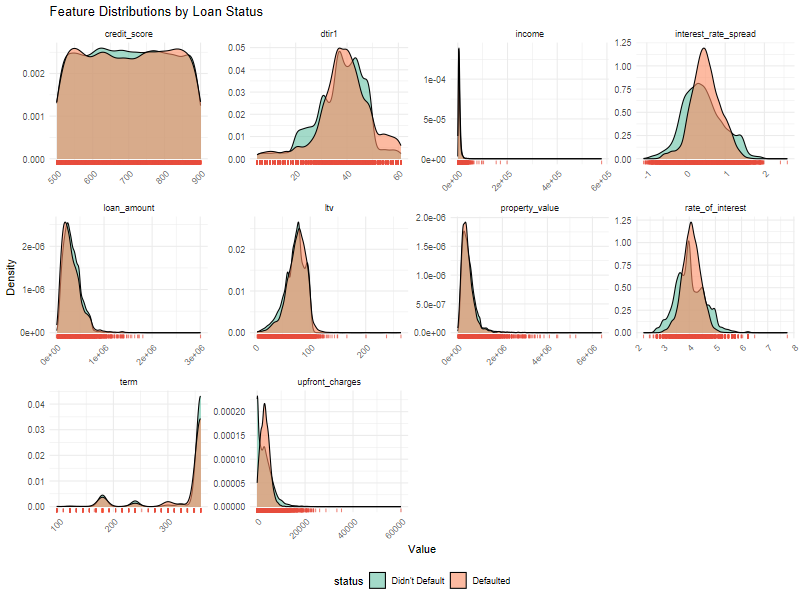

In [92]:
numeric_features <- imputed_data %>%
  select(any_of(c(numeric_cols, "status"))) %>%
  pivot_longer(cols = -status, names_to = "features", values_to = "values")

p1 <- ggplot(numeric_features, aes(values, fill = status)) +
  geom_density(alpha = 0.6) +
  geom_rug(alpha = 0.7, color = "#e74c3c") +
  facet_wrap(~features, scales = "free") +
labs(title = "Feature Distributions by Loan Status",
  x = "Value", y = "Density") +
    scale_fill_manual(values = c("Didn't Default" = "#66c2a5", 
  "Defaulted" = "#fc8d62")) +
theme_minimal() +
theme(axis.text.x = element_text(angle = 45, hjust = 1),
   legend.position = "bottom")

p1

In [91]:
p2 <- ggplot(numeric_features, aes())

p2

# A tibble: 200,000 × 3
   status         features                  values
   <fct>          <chr>                      <dbl>
 1 Didn't Default loan_amount           706500    
 2 Didn't Default rate_of_interest           3.99 
 3 Didn't Default interest_rate_spread       0.152
 4 Didn't Default upfront_charges          370    
 5 Didn't Default term                     360    
 6 Didn't Default property_value       1008000    
 7 Didn't Default income                 10080    
 8 Didn't Default credit_score             864    
 9 Didn't Default ltv                       70.1  
10 Didn't Default dtir1                     40    
# ℹ 199,990 more rows
# ℹ Use `print(n = ...)` to see more rows

There were 14 warnings (use warnings() to see them)


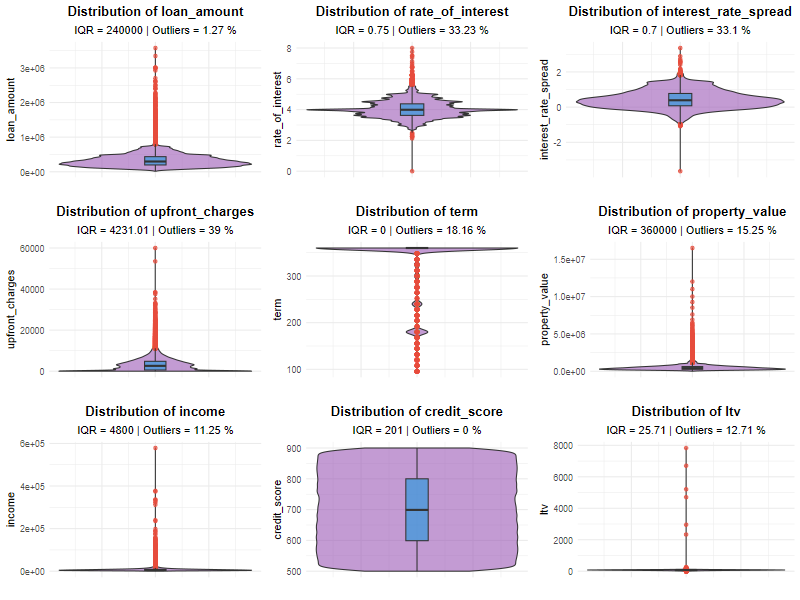

In [95]:
if(length(numeric_cols) > 0) {
  # Create a function for advanced boxplots
  advanced_boxplot <- function(data, variable) {
    # Calculate outlier bounds
    q1 <- quantile(data[[variable]], 0.25, na.rm = TRUE)
    q3 <- quantile(data[[variable]], 0.75, na.rm = TRUE)
    iqr <- q3 - q1
    lower_bound <- q1 - 1.5 * iqr
    upper_bound <- q3 + 1.5 * iqr
    
    # Calculate percentage of outliers
    outliers <- data[[variable]][data[[variable]] < lower_bound | data[[variable]] > upper_bound]
    outlier_pct <- length(outliers) / length(na.omit(data[[variable]])) * 100
    
    p <- ggplot(data, aes_string(y = variable, x = 1)) +
      geom_violin(fill = "#9b59b6", alpha = 0.6) +
      geom_boxplot(width = 0.1, fill = "#3498db", alpha = 0.7, outlier.color = "#e74c3c") +
      labs(
        title = paste("Distribution of", variable),
        subtitle = paste(
          "IQR =", round(iqr, 2),
          "| Outliers =", round(outlier_pct, 2), "%"
        ),
        y = variable, x = ""
      ) +
      theme_minimal() +
      theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank()
      )
    
    return(p)
  }
  
  # Create boxplots for the first 9 numeric variables
  plot_list <- lapply(numeric_cols[1:min(9, length(numeric_cols))], 
                     function(col) advanced_boxplot(loan_data, col))
  do.call(grid.arrange, c(plot_list, ncol = 3))
}

## Distribution of categorical features

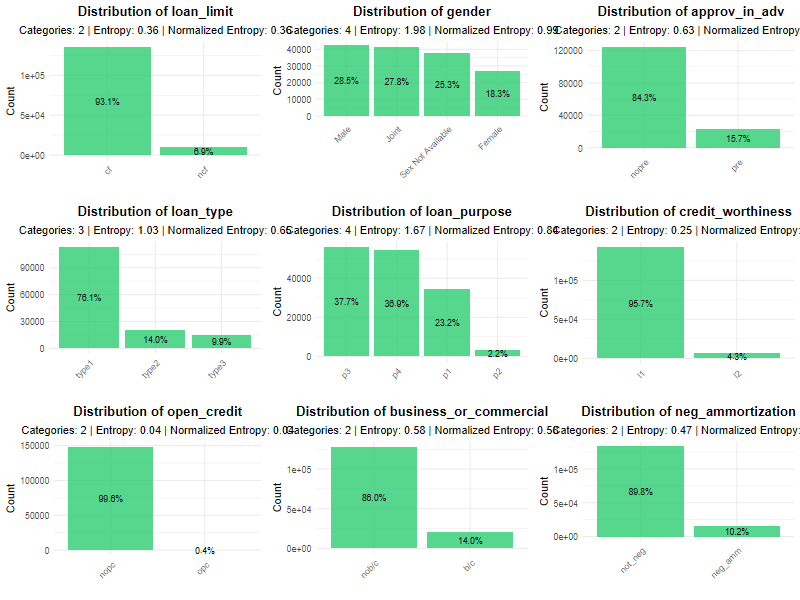

In [98]:
categorical_cols <- imputed_data %>% 
  select_if(is.factor) %>% 
  names()

if(length(categorical_cols) > 0) {
  # Create a function for advanced bar charts
  advanced_bar_chart <- function(data, variable) {
    # Calculate frequencies and percentages
    freq_table <- table(data[[variable]])
    freq_df <- data.frame(
      Category = names(freq_table),
      Count = as.numeric(freq_table),
      Percentage = as.numeric(freq_table) / sum(freq_table) * 100
    ) %>%
      arrange(desc(Count))
    
    # Calculate Shannon's entropy (measure of dispersion)
    p <- freq_df$Percentage / 100
    entropy <- -sum(p * log2(p), na.rm = TRUE)
    max_entropy <- log2(length(freq_df$Category))
    norm_entropy <- entropy / max_entropy
    
    # Create the plot
    p <- ggplot(freq_df, aes(x = reorder(Category, -Count), y = Count)) +
      geom_bar(stat = "identity", fill = "#2ecc71", alpha = 0.8) +
      geom_text(aes(label = sprintf("%.1f%%", Percentage)), 
                position = position_stack(vjust = 0.5), 
                color = "black", size = 3) +
      labs(
        title = paste("Distribution of", variable),
        subtitle = paste(
          "Categories:", length(freq_df$Category),
          "| Entropy:", round(entropy, 2),
          "| Normalized Entropy:", round(norm_entropy, 2)
        ),
        x = "",
        y = "Count"
      ) +
      theme_minimal() +
      theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5),
        axis.text.x = element_text(angle = 45, hjust = 1)
      )
    
    return(p)
  }
  
  # Create bar charts for the first 9 categorical variables
  plot_list <- lapply(categorical_cols[1:min(9, length(categorical_cols))], 
                      function(col) advanced_bar_chart(loan_data, col))
  do.call(grid.arrange, c(plot_list, ncol = 3))
}

# 4. Bivariate Analysis

## 4.1 Relationship Between Target Variable and Numeric Predictors

Warning messages:
1: Removed 17122 rows containing non-finite outside the scale range
(`stat_ydensity()`). 
2: Removed 17122 rows containing non-finite outside the scale range
(`stat_boxplot()`). 


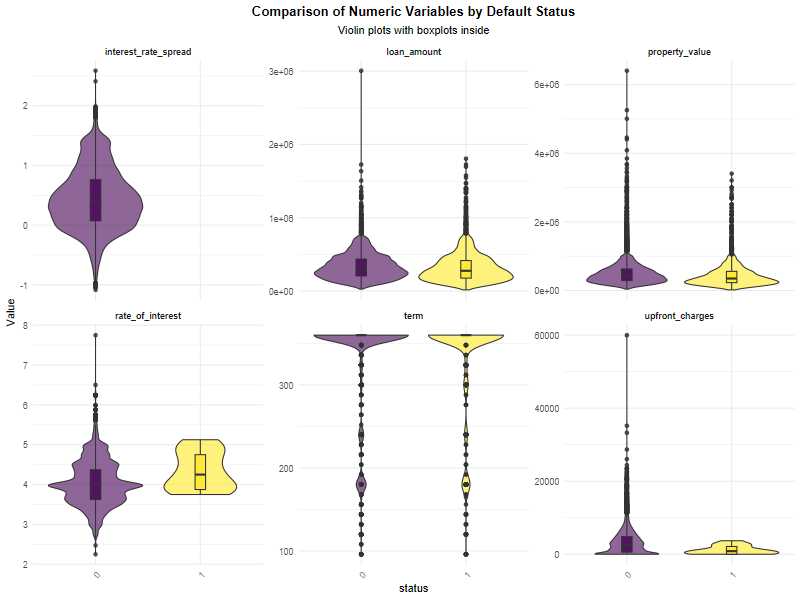

In [105]:
# Identify the target variable (assuming 'Default' is the target)
target_var <- "status"

if(target_var %in% names(data) && is.factor(data[[target_var]])) {
  # Create advanced ridge plots
  ridge_plot_data <- data %>%
    select(all_of(c(target_var, numeric_cols[1:min(6, length(numeric_cols))]))) %>%
    pivot_longer(cols = -all_of(target_var), names_to = "Variable", values_to = "Value")
  
  ggplot(ridge_plot_data, aes(x = Value, y = Variable, fill = .data[[target_var]])) +
    geom_density_ridges(alpha = 0.6, scale = 2, quantile_lines = TRUE, quantiles = 2) +
    scale_fill_viridis_d() +
    labs(
      title = "Distribution of Numeric Variables by Default Status",
      subtitle = "Showing density ridges with median lines",
      x = "Value",
      y = "Variable"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5),
      legend.position = "top"
    )
  
  # Create violin plots with boxplots inside
  violin_plot_data <- ridge_plot_data
  
  ggplot(violin_plot_data, aes(x = .data[[target_var]], y = Value, fill = .data[[target_var]])) +
    geom_violin(alpha = 0.6) +
    geom_boxplot(width = 0.1, alpha = 0.8) +
    scale_fill_viridis_d() +
    facet_wrap(~ Variable, scales = "free_y", ncol = 3) +
    labs(
      title = "Comparison of Numeric Variables by Default Status",
      subtitle = "Violin plots with boxplots inside",
      x = target_var,
      y = "Value"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5),
      legend.position = "none",
      strip.text = element_text(face = "bold"),
      axis.text.x = element_text(angle = 45, hjust = 1)
    ) 
}

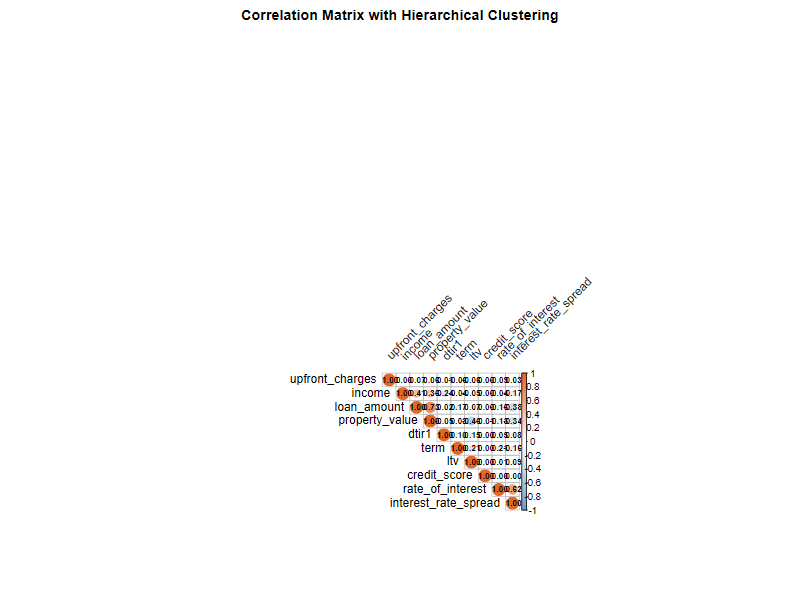

: [1m[33mError[39m in `graph_from_data_frame()`:[22m
[33m![39m could not find function "graph_from_data_frame"

In [107]:
if(length(numeric_cols) > 1) {
  cor_matrix <- cor(data[, numeric_cols], use = "pairwise.complete.obs")
  
  # Advanced correlation heatmap with hierarchical clustering
  corrplot(cor_matrix, 
           method = "circle", 
           type = "upper", 
           order = "hclust",
           tl.col = "black", 
           tl.srt = 45,
           col = colorRampPalette(c("#6D9EC1", "white", "#E46726"))(200),
           addCoef.col = "black",
           number.cex = 0.7,
           title = "Correlation Matrix with Hierarchical Clustering",
           mar = c(0, 0, 2, 0))
  
  # Create a network plot for strong correlations
  strong_cor <- which(abs(cor_matrix) > 0.5 & abs(cor_matrix) < 1, arr.ind = TRUE)
  
  if(nrow(strong_cor) > 0) {
    cor_network_data <- data.frame(
      var1 = numeric_cols[strong_cor[, 1]],
      var2 = numeric_cols[strong_cor[, 2]],
      correlation = cor_matrix[strong_cor]
    )
    
    # Create a graph data frame
    network_df <- data.frame(
      from = cor_network_data$var1,
      to = cor_network_data$var2,
      weight = abs(cor_network_data$correlation),
      color = ifelse(cor_network_data$correlation > 0, "positive", "negative")
    )
    
    # Create a graph
    g <- graph_from_data_frame(network_df, directed = FALSE)
    
    # Plot the graph
    set.seed(42)
    ggplot(network_df, aes(from_id = from, to_id = to, edge_width = weight, edge_color = color)) +
      geom_net(layout.alg = "fruchtermanreingold", 
              size = 4, 
              label = TRUE, 
              labelsize = 3, 
              fontsize = 3,
              ecolour = c("positive" = "#3498db", "negative" = "#e74c3c")) +
      scale_edge_colour_manual(values = c("positive" = "#3498db", "negative" = "#e74c3c")) +
      labs(
        title = "Network of Strong Correlations (|r| > 0.5)",
        subtitle = "Line width represents correlation strength; blue = positive, red = negative"
      ) +
      theme_minimal() +
      theme(
        plot.title = element_text(face = "bold", hjust = 0.5),
        plot.subtitle = element_text(hjust = 0.5)
      )
  }
}



# 5. Multivariate Analysis

## 5.1 Advanced Scatter Plot Matrix

# Select a subset of the most interesting numeric variables

There were 42 warnings (use warnings() to see them)


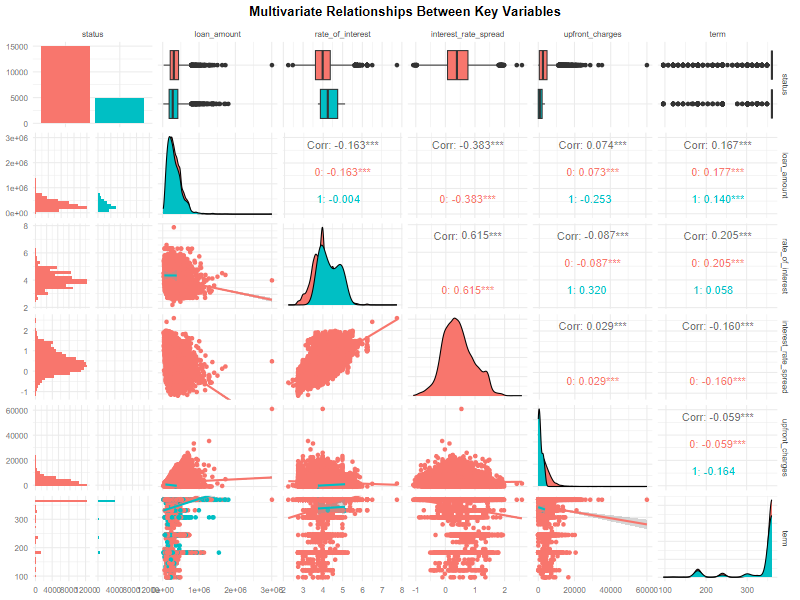

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

In [109]:
if(length(numeric_cols) > 3) {
  selected_vars <- c(
    # Choose most informative variables or first few variables if feature importance not available
    numeric_cols[1:5]
  )
  
  if(target_var %in% names(data) && is.factor(data[[target_var]])) {
    selected_vars <- c(target_var, selected_vars)
  }
  
  # Create an advanced scatter plot matrix
  ggpairs(
    data[, selected_vars],
    aes(color = if(target_var %in% names(data) && 
                 is.factor(data[[target_var]])) data[[target_var]] else NULL),
    upper = list(continuous = "cor", combo = "box_no_facet"),
    lower = list(continuous = "smooth", combo = "facethist"),
    diag = list(continuous = "densityDiag", discrete = "barDiag"),
    axisLabels = "show",
    title = "Multivariate Relationships Between Key Variables"
  ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      axis.text = element_text(size = 8),
      strip.text = element_text(size = 8)
    )
}

## 5.2 Dimensionality Reduction and Visualization

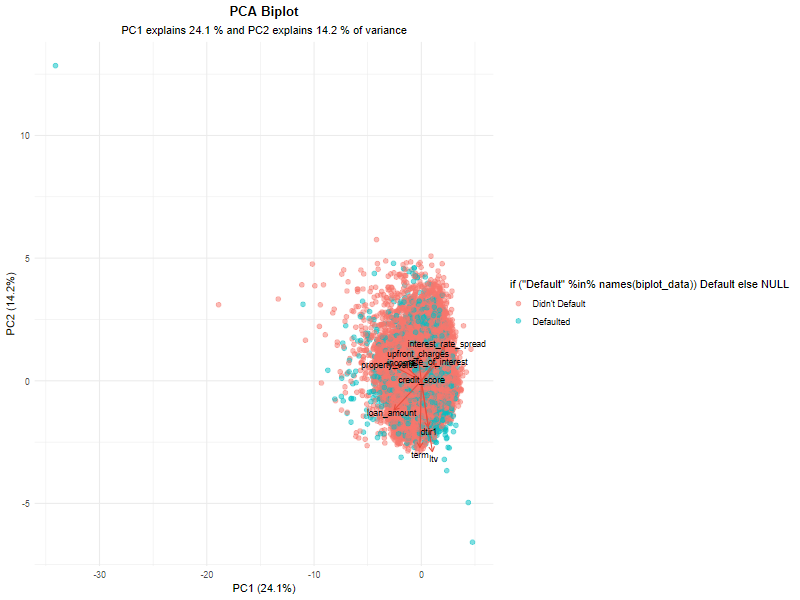

In [115]:
if(length(numeric_cols) > 2) {
  # Standardize the data
  pca_data <- scale(imputed_data[, numeric_cols], center = TRUE, scale = TRUE)
  
  # Perform PCA
  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)
  
  # Calculate variance explained
  var_explained <- pca_result$sdev^2 / sum(pca_result$sdev^2)
  cum_var_explained <- cumsum(var_explained)
  
  # Create scree plot
  var_df <- data.frame(
    Principal_Component = paste0("PC", 1:length(var_explained)),
    Variance_Explained = var_explained,
    Cumulative_Variance = cum_var_explained
  )
  
  p1 <- ggplot(var_df[1:10,], aes(x = Principal_Component, y = Variance_Explained)) +
    geom_col(fill = "#3498db", alpha = 0.8) +
    geom_line(aes(y = Cumulative_Variance, group = 1), 
             color = "#e74c3c", size = 1.2) +
    geom_point(aes(y = Cumulative_Variance), 
              color = "#e74c3c", size = 3) +
    scale_y_continuous(
      name = "Proportion of Variance Explained",
      sec.axis = sec_axis(~., name = "Cumulative Proportion")
    ) +
    labs(
      title = "Scree Plot of Principal Components",
      subtitle = paste("First 2 PCs explain", 
                     round(cum_var_explained[2] * 100, 1), "% of variance"),
      x = "Principal Component"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  print(p1)
  
  # Create biplot
  biplot_data <- as.data.frame(pca_result$x[, 1:2])
  colnames(biplot_data) <- c("PC1", "PC2")
  
  if(target_var %in% names(imputed_data) && is.factor(imputed_data[[target_var]])) {
    biplot_data$Default <- imputed_data[[target_var]]
  }
  
  # Calculate variable contributions to PCs
  loadings <- as.data.frame(pca_result$rotation[, 1:2])
  loadings$variable <- rownames(loadings)
  
  p2 <- ggplot(biplot_data, aes(x = PC1, y = PC2)) +
    geom_point(aes(color = if("Default" %in% names(biplot_data)) Default else NULL), 
              alpha = 0.5, size = 2) +
    geom_segment(data = loadings, 
                aes(x = 0, y = 0, xend = PC1 * 5, yend = PC2 * 5), 
                arrow = arrow(length = unit(0.2, "cm")), 
                color = "#e74c3c") +
    geom_text(data = loadings, 
             aes(x = PC1 * 5.5, y = PC2 * 5.5, label = variable), 
             size = 3) +
    labs(
      title = "PCA Biplot",
      subtitle = paste("PC1 explains", 
                     round(var_explained[1] * 100, 1), 
                     "% and PC2 explains", 
                     round(var_explained[2] * 100, 1), 
                     "% of variance"),
      x = paste0("PC1 (", round(var_explained[1] * 100, 1), "%)"),
      y = paste0("PC2 (", round(var_explained[2] * 100, 1), "%)")
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  print(p2)
}

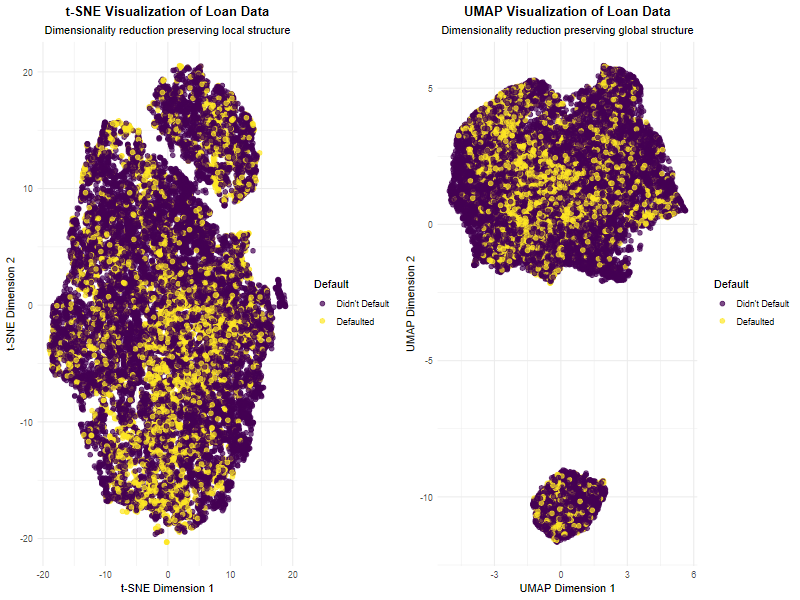

In [114]:
# Advanced dimensionality reduction techniques: t-SNE and UMAP
if(length(numeric_cols) > 2 && target_var %in% names(imputed_data) && is.factor(imputed_data[[target_var]])) {
  # Standardize the data
  std_data <- scale(imputed_data[, numeric_cols], center = TRUE, scale = TRUE)
  
  # Perform t-SNE
  set.seed(42)
  tsne_result <- Rtsne(std_data, dims = 2, perplexity = 30, verbose = FALSE, max_iter = 500)
  
  # Create t-SNE plot
  tsne_df <- data.frame(
    tSNE1 = tsne_result$Y[, 1],
    tSNE2 = tsne_result$Y[, 2],
    Default = imputed_data[[target_var]]
  )
  
  p1 <- ggplot(tsne_df, aes(x = tSNE1, y = tSNE2, color = Default)) +
    geom_point(alpha = 0.7, size = 2) +
    scale_color_viridis_d() +
    labs(
      title = "t-SNE Visualization of Loan Data",
      subtitle = "Dimensionality reduction preserving local structure",
      x = "t-SNE Dimension 1",
      y = "t-SNE Dimension 2"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  # Perform UMAP
  set.seed(42)
  umap_result <- umap(std_data, n_neighbors = 15, min_dist = 0.1)
  
  # Create UMAP plot
  umap_df <- data.frame(
    UMAP1 = umap_result$layout[, 1],
    UMAP2 = umap_result$layout[, 2],
    Default = imputed_data[[target_var]]
  )
  
  p2 <- ggplot(umap_df, aes(x = UMAP1, y = UMAP2, color = Default)) +
    geom_point(alpha = 0.7, size = 2) +
    scale_color_viridis_d() +
    labs(
      title = "UMAP Visualization of Loan Data",
      subtitle = "Dimensionality reduction preserving global structure",
      x = "UMAP Dimension 1",
      y = "UMAP Dimension 2"
    ) +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  # Plot side by side
  grid.arrange(p1, p2, ncol = 2)
}

# 6. Feature Importance and Selection

## 6.1 Statistical Tests for Feature Selection

In [116]:
if(target_var %in% names(imputed_data) && is.factor(imputed_data[[target_var]])) {
  # Initialize a dataframe to store feature importance results
  feature_importance <- data.frame(
    Feature = character(),
    p_value = numeric(),
    effect_size = numeric(),
    stringsAsFactors = FALSE
  )
  
  # Perform statistical tests for numeric features
  for(feat in numeric_cols) {
    # Perform Wilcoxon rank-sum test (non-parametric alternative to t-test)
    test_result <- wilcox.test(
      imputed_data[[feat]] ~ imputed_data[[target_var]], 
      exact = FALSE
    )
    
    # Calculate effect size (Cliff's delta)
    effect_size <- effsize::cliff.delta(
      imputed_data[[feat]] ~ imputed_data[[target_var]]
    )$estimate
    
    # Add to the dataframe
    feature_importance <- rbind(
      feature_importance,
      data.frame(
        Feature = feat,
        p_value = test_result$p.value,
        effect_size = abs(effect_size),
        stringsAsFactors = FALSE
      )
    )
  }
  
  # Perform chi-square tests for categorical features
  for(feat in categorical_cols) {
    if(feat != target_var) {
      # Contingency table
      cont_table <- table(imputed_data[[feat]], imputed_data[[target_var]])
      
      # Chi-square test
      test_result <- chisq.test(cont_table)
      
      # Calculate Cramer's V
      cramer_v <- sqrt(test_result$statistic / 
                     (sum(cont_table) * min(nrow(cont_table) - 1, ncol(cont_table) - 1)))
      
      # Add to the dataframe
      feature_importance <- rbind(
        feature_importance,
        data.frame(
          Feature = feat,
          p_value = test_result$p.value,
          effect_size = cramer_v,
          stringsAsFactors = FALSE
        )
      )
    }
  }
  # Adjust p-values for multiple testing
  feature_importance$adjusted_p_value <- p.adjust(feature_importance$p_value, method = "BH")
  
  # Sort by effect size
  feature_importance <- feature_importance %>%
    arrange(desc(effect_size))
  
  # Visualize feature importance
  ggplot(feature_importance, aes(x = reorder(Feature, effect_size), y = effect_size)) +
    geom_bar(stat = "identity", fill = "#3498db", alpha = 0.8) +
    geom_point(aes(color = adjusted_p_value < 0.05), size = 3) +
    scale_color_manual(values = c("FALSE" = "#e74c3c", "TRUE" = "#2ecc71"),
                       name = "Significant\n(adj. p < 0.05)") +
    labs(
      title = "Feature Importance Based on Statistical Tests",
      subtitle = "Effect size with significance indicators",
      x = "Feature",
      y = "Effect Size (absolute)"
    ) +
    coord_flip() +
    theme_minimal() +
    theme(
      plot.title = element_text(face = "bold", hjust = 0.5),
      plot.subtitle = element_text(hjust = 0.5)
    )
  
  # Display the top features
  feature_importance %>%
    slice_head(n = 10) %>%
    kable(caption = "Top 10 Features by Effect Size", digits = 4) %>%
    kable_styling()
}
  

Warning messages:
1: In chisq.test(cont_table) : Chi-squared approximation may be incorrect
2: In chisq.test(cont_table) : Chi-squared approximation may be incorrect
3: In chisq.test(cont_table) : Chi-squared approximation may be incorrect


: [1m[33mError[39m in `x$sizingPolicy`:[22m
[33m![39m $ operator is invalid for atomic vectors

## 6.2 Machine Learning-Based Feature Importance